In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tokenizers

In [2]:
!mkdir 'data'

In [3]:
!tar -xzvf '/content/drive/MyDrive/for_atom/aclImdb_v1.tar.gz' -C '/content/data'


Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclI

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Input, Dropout,  Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l1, l2
from sklearn.utils import shuffle
# from tokenizers import Tokenizer
# from tokenizers.models import BPE
# from tokenizers.pre_tokenizers import Whitespace
# from tokenizers.trainers import BpeTrainer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
del train_df
del test_df
del data_train
del data_test

In [30]:
import os
import pandas as pd
data_train = {'review': [], 'rating': []}
data_test = {'review': [], 'rating': []}
def load_data(directory, data):
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            rating = filename.split('_')[1].replace('.txt', '')
            path = os.path.join(directory, filename)
            with open(path, 'r', encoding='utf-8') as file:
                review = file.read()
            data['review'].append(review)
            data['rating'].append(rating)
    return pd.DataFrame(data)




In [31]:
train_df = load_data('/content/data/aclImdb/train/pos', data_train)
train_df = load_data('/content/data/aclImdb/train/neg', data_train)
train_df = shuffle(train_df)

In [32]:
test_df = load_data('/content/data/aclImdb/test/neg', data_test)
test_df = load_data('/content/data/aclImdb/test/pos', data_test)
test_df = shuffle(test_df)

In [33]:
train_df.shape

(25000, 2)

In [9]:
train_df.shape

(25000, 2)

In [34]:
train_df.groupby('rating').count()

,review
rating,
1,5100
10,4732
2,2284
3,2420
4,2696
7,2496
8,3009
9,2263


In [35]:
test_df.groupby('rating').count()

,review
rating,
1,5022
10,4999
2,2302
3,2541
4,2635
7,2307
8,2850
9,2344


In [12]:
a = train_df['rating'].unique().astype(int)
a.sort()
print(a)

[ 1  2  3  4  7  8  9 10]


In [13]:
b = test_df['rating'].unique().astype(int)
b.sort()
print(b)

[ 1  2  3  4  7  8  9 10]


In [69]:
test_df['rating'] = test_df['rating'].astype(int)
train_df['rating'] = train_df['rating'].astype(int)
mapping = {1:0, 2:1, 3:2, 4:3, 7:4, 8:5, 9:6, 10:7}
train_df['rating'] = train_df['rating'].map(mapping)
test_df['rating'] = test_df['rating'].map(mapping)

# Проверка уникальных значений после преобразования
print(test_df['rating'].unique())

[5 2 7 4 1 0 6 3]


In [36]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
def remove_stopwords(text):
  words = nltk.word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in stop_words and word.isalnum()]
  return " ".join(filtered_words)

In [38]:
train_df['filtered'] = train_df['review'].apply(remove_stopwords)
test_df['filtered'] = test_df['review'].apply(remove_stopwords)
train_df[['review', 'filtered']]

,review,filtered
20304,Chinese Ghost Story III is a totally superfluo...,Chinese Ghost Story III totally superfluous se...
5924,When I first started watching this anime I nev...,first started watching anime never thought som...
23405,"""What happens when you give a homeless man $10...",happens give homeless man asking question some...
7424,"I have to admit, I wasn't expecting much going...",admit expecting much going film viewing Japene...
20286,This film really got off to a great start. It ...,film really got great start potential turn rea...
...,...,...
5021,It seems that it is becoming fashionable to ri...,seems becoming fashionable rip Basic Instinct ...
14243,"Well, I hate hollywood, but love cinema so i h...",Well hate hollywood love cinema watch cruddy m...
2446,One of the less widely lauded of recent Asian ...,One less widely lauded recent Asian period act...
16199,"I absolutely hate this programme, what kind of...",absolutely hate programme kind people sit watc...


In [40]:
import re
def remove_html(text):
  clean = re.compile('<.*?>|&.*?;')
  return re.sub(clean, '', text)

In [41]:
train_df['filtered'] = train_df['filtered'].apply(remove_html)
test_df['filtered'] = test_df['filtered'].apply(remove_html)
train_df[['review', 'filtered']]

,review,filtered
20304,Chinese Ghost Story III is a totally superfluo...,Chinese Ghost Story III totally superfluous se...
5924,When I first started watching this anime I nev...,first started watching anime never thought som...
23405,"""What happens when you give a homeless man $10...",happens give homeless man asking question some...
7424,"I have to admit, I wasn't expecting much going...",admit expecting much going film viewing Japene...
20286,This film really got off to a great start. It ...,film really got great start potential turn rea...
...,...,...
5021,It seems that it is becoming fashionable to ri...,seems becoming fashionable rip Basic Instinct ...
14243,"Well, I hate hollywood, but love cinema so i h...",Well hate hollywood love cinema watch cruddy m...
2446,One of the less widely lauded of recent Asian ...,One less widely lauded recent Asian period act...
16199,"I absolutely hate this programme, what kind of...",absolutely hate programme kind people sit watc...


In [53]:
!pip install pymorphy2
import pymorphy2 as p2

morth = p2.MorphAnalyzer()
def lematisation(array):
    array = array.split(' ')
    return [morth.parse(item)[0].normal_form for item in array]


In [49]:
word = morth.parse("people")[0].normal_form
word

'people'

In [54]:
train_df['filtered'].apply(lematisation)

,filtered
20304,"[chinese, ghost, story, iii, totally, superflu..."
5924,"[first, started, watching, anime, never, thoug..."
23405,"[happens, give, homeless, man, asking, questio..."
7424,"[admit, expecting, much, going, film, viewing,..."
20286,"[film, really, got, great, start, potential, t..."
...,...
5021,"[seems, becoming, fashionable, rip, basic, ins..."
14243,"[well, hate, hollywood, love, cinema, watch, c..."
2446,"[one, less, widely, lauded, recent, asian, per..."
16199,"[absolutely, hate, programme, kind, people, si..."


In [55]:
train_df['filtered'] = train_df['filtered'].apply(lematisation)
test_df['filtered'] = test_df['filtered'].apply(lematisation)

In [65]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
class BpeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len  # Максимальная длина для паддинга

    def fit(self, X, y=None):
        return self  # Ничего не делаем, возвращаем себя

    def transform(self, X):
        # Убеждаемся, что X не содержит None и все элементы являются строками
        clean_texts = [str(text) for text in X if text is not None]
        # Токенизируем данные и преобразуем их в последовательность индексов
        tokenized = [self.tokenizer.encode(text).ids for text in clean_texts]
        # Применяем паддинг до max_len с помощью numpy
        padded = np.array([self.pad_sequence(seq) for seq in tokenized])
        return padded

    def pad_sequence(self, sequence):
        # Если последовательность короче max_len, добавляем нули
        if len(sequence) < self.max_len:
            return np.pad(sequence, (0, self.max_len - len(sequence)), 'constant')
        # Если последовательность длиннее, обрезаем до max_len
        return sequence[:self.max_len]

max_len = 250  # Это может варьироваться в зависимости от данных

# Инициализируем токенизатор и тренер
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train_from_iterator(train_df['filtered'].tolist(), trainer)

# Создаем экземпляр нашего кастомного BPE векторизатора
bpe_vectorizer = BpeVectorizer(tokenizer=tokenizer, max_len=max_len)

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler

# Вам нужен другой векторизатор, который сможет обрабатывать числовые индексы токенов,
# например, преобразовывая индексы в разреженные векторы
pipeline = Pipeline([
    ('vectorizer', bpe_vectorizer),
    ('scaler', MaxAbsScaler()),  # Масштабируем фичи, так как индексы могут быть большими числами
    ('classifier', LogisticRegression())
])


In [61]:
train_df['filtered'] = train_df['filtered'].fillna('').astype(str)
test_df['filtered'] = test_df['filtered'].fillna('').astype(str)

In [71]:
model2 = pipeline.fit(train_df['filtered'], train_df['rating'])

In [72]:
model2

Pipeline(steps=[('vectorizer',
                 BpeVectorizer(max_len=250,
                               tokenizer=<tokenizers.Tokenizer object at 0x7a0b29209830>)),
                ('scaler', MaxAbsScaler()),
                ('classifier', LogisticRegression())])

In [73]:
accuracy = model2.score(test_df['filtered'], test_df['rating'])
print(f"Accuracy on test set: {accuracy:.2%}")




Accuracy on test set: 20.23%


In [81]:
predicted_ratings = model2.predict(test_df['filtered'])

# Присвоение предсказаний в DataFrame
test_df['predicted_ratings'] = predicted_ratings

# Подсчёт правильных предсказаний по каждому классу
accuracy_per_class = test_df[test_df['rating'] == test_df['predicted_ratings']].groupby('rating').size() / test_df.groupby('rating').size()

# Вывод accuracy_per_class
print(accuracy_per_class)

rating
0    0.594982
1    0.009557
2    0.025580
3    0.050854
4    0.039445
5    0.088772
6    0.020051
7    0.291658
dtype: float64


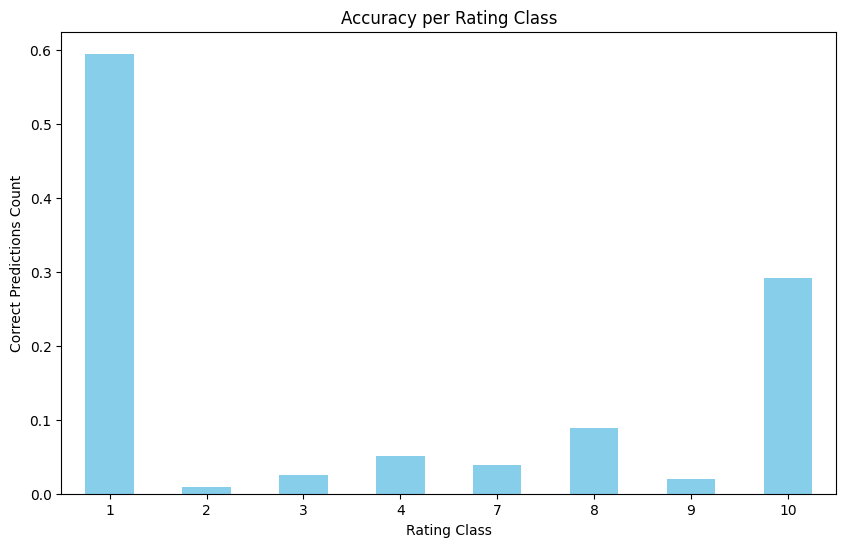

In [82]:
plt.figure(figsize=(10, 6))
accuracy_per_class.plot(kind='bar', color='skyblue')
plt.title('Accuracy per Rating Class')
plt.xlabel('Rating Class')
plt.ylabel('Correct Predictions Count')
plt.xticks(range(8), ['1', '2', '3', '4', '7', '8', '9', '10'], rotation=0)
plt.show()

In [ ]:
train_df.groupby('rating').count() / train_df.shape[0] * 100

,review
rating,
0,20.400
1,9.136
2,9.680
3,10.784
4,9.984
5,12.036
6,9.052
7,18.928


In [113]:
max_words = 30000
max_review_len = 350

**Дефолтный токенизатор**

In [96]:
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(train_df['filtered'])
sequences_train = [tokenizer.encode(text).ids for text in train_df['filtered']]

sequences_test = [tokenizer.encode(text).ids for text in test_df['filtered']]

In [97]:
print(len(sequences_test[0]))
print(len(test_df['review'][0]))

429
928


In [101]:
max_index = max(max(seq) for seq in sequences_train if len(seq) > 0)
print(f'Max index: {max_index}')

Max index: 29999


In [114]:
X_train = pad_sequences(sequences_train, maxlen=max_review_len)
X_test = pad_sequences(sequences_test, maxlen=max_review_len)
y_test = utils.to_categorical(test_df['rating'], 8)
y_train = utils.to_categorical(train_df['rating'], 8)

In [118]:
model = Sequential([
    Input(shape=(max_review_len,)),
    Embedding(input_dim=max_words, output_dim=100),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    LSTM(64, kernel_regularizer=l2(0.001)),
    Dense(8, activation='softmax')
])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [119]:
history = model.fit(X_train, y_train, batch_size=512, epochs=3, validation_split=0.1)

Epoch 1/3
44/44 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.1730 - loss: 2.2109 - val_accuracy: 0.2164 - val_loss: 2.1099
Epoch 2/3
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2726 - loss: 2.0372 - val_accuracy: 0.3576 - val_loss: 1.7298
Epoch 3/3
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4211 - loss: 1.5537 - val_accuracy: 0.4008 - val_loss: 1.5913


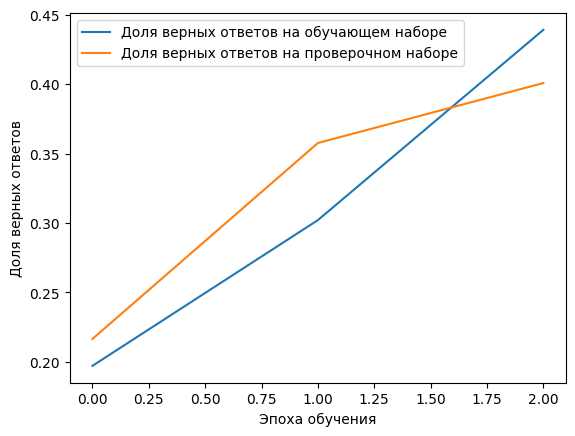

In [120]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [121]:
predictions = model.predict(X_test, verbose=1)
predicted_ratings = predictions.argmax(axis=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step


In [122]:
model.evaluate(X_test, y_test, verbose=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.3975 - loss: 1.5974


[1.6009626388549805, 0.39824000000953674]

In [123]:
test_df['predicted_ratings'] = np.array(predicted_ratings)

In [124]:
test_df[['rating', 'predicted_ratings']]

,rating,predicted_ratings
18922,5,5
9104,2,0
15825,7,7
15278,4,5
6177,1,7
...,...,...
21516,7,7
22555,7,0
8525,0,4
20151,7,7


In [125]:
accuracy_per_class = test_df[test_df['rating'] == test_df['predicted_ratings']].groupby('rating').size() / test_df.groupby('rating').size()

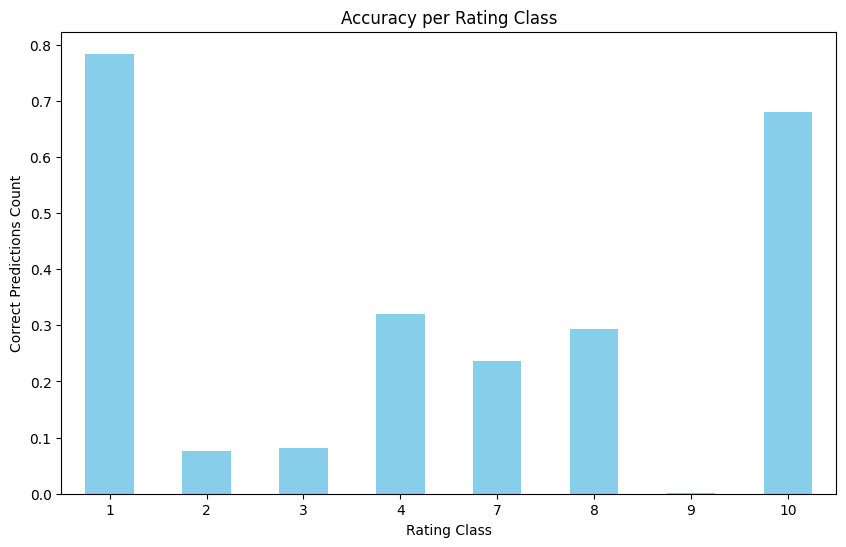

In [126]:
plt.figure(figsize=(10, 6))
accuracy_per_class.plot(kind='bar', color='skyblue')
plt.title('Accuracy per Rating Class')
plt.xlabel('Rating Class')
plt.ylabel('Correct Predictions Count')
plt.xticks(range(8), ['1', '2', '3', '4', '7', '8', '9', '10'], rotation=0)
plt.show()

In [127]:
model.save('my_model2.keras')